Include the upper directory to the path to access the library.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In this example, we use the Kernighan-Lin algorithm for graph partition.

In [2]:
from engines.mcmc import *
mcmc = MCMC(f_engine="../engines/bipartiteSBM-MCMC/bin/mcmc",  # path to the graph partitioning binary
            n_sweeps=4,                                        # number of partitioning computations for each (K1, K2) data point
            is_parallel=True,                                  # whether to compute the partitioning in parallel
            n_cores=4,                                         # if `is_parallel == True`, the number of cores used   
            mcmc_steps=1000000,                                # [MCMC] the number of sweeps
            mcmc_await_steps=100000,                           # [MCMC] the number of sweeps to await until stopping the algorithm, if max(entropy) and min(entropy) show no change therein  
            mcmc_cooling="constant",                           # [MCMC] annealing scheme used. enum: ["exponential", "logarithm", "linear", "constant"].
            mcmc_cooling_param_1=0.1,                          # [MCMC] parameter 1 for the annealing
            mcmc_cooling_param_2=0.1,                          # [MCMC] parameter 2 for the annealing
            mcmc_epsilon=0.01                                  # [MCMC] the "epsilon" value used in the algorithm
        )

Here, we initiate the Python class for the heuristic.

In [3]:
from det_k_bisbm.optimalks import *
from det_k_bisbm.ioutils import *

edgelist = get_edgelist("../dataset/malaria.edgelist", "\t")
types= mcmc.gen_types(297, 806)

oks = OptimalKs(mcmc, edgelist, types)
oks.set_params(init_ka=15, init_kb=15, i_th=0.1)
oks.set_adaptive_ratio(0.9)
oks.set_exist_bookkeeping(True)
oks.set_logging_level("info")

We could also generate a command-line string for single-point computation. 

In [4]:
mcmc.prepare_engine("../dataset/malaria.edgelist", 297, 806, 12, 9)

'../engines/bipartiteSBM-MCMC/bin/mcmc -e ../dataset/malaria.edgelist -n 25 25 25 25 25 25 25 25 25 24 24 24 90 90 90 90 90 89 89 89 89 -t 1000000 -x 100000 --maximize -c constant -a 0.1 -y 297 806 -z 12 9 -E 0.01 --randomize'

Let's start by (15, 15) and see how the heuristic finds the number of communities. Please run it several times to ensure that the global minimum is found.

In [5]:
oks.iterator()

2017-09-30 03:08:17,995:INFO:Now computing graph partition at (15, 15) ...
2017-09-30 03:08:21,738:INFO:... DONE.
2017-09-30 03:08:22,589:INFO:Now computing graph partition at (12, 11) ...
2017-09-30 03:08:25,238:INFO:... DONE.
2017-09-30 03:08:26,005:INFO:Now computing graph partition at (12, 12) ...
2017-09-30 03:08:29,886:INFO:... DONE.
2017-09-30 03:08:30,579:INFO:Now computing graph partition at (12, 13) ...
2017-09-30 03:08:35,021:INFO:... DONE.
2017-09-30 03:08:35,734:INFO:Now computing graph partition at (13, 12) ...
2017-09-30 03:08:42,439:INFO:... DONE.
2017-09-30 03:08:43,120:INFO:Now computing graph partition at (12, 14) ...
2017-09-30 03:08:46,277:INFO:... DONE.
2017-09-30 03:08:46,949:INFO:Now computing graph partition at (12, 14) ...
2017-09-30 03:08:46,950:INFO:... fetch calculated data ...
2017-09-30 03:08:46,951:INFO:... DONE.
2017-09-30 03:08:47,584:INFO:Now computing graph partition at (13, 13) ...
2017-09-30 03:08:51,618:INFO:... DONE.
2017-09-30 03:08:52,274:INFO:

OrderedDict([((15, 15), -0.88532071173144411),
             ((12, 11), -0.80879428008080101),
             ((12, 12), -0.80059869694251018),
             ((12, 13), -0.80792045173712446),
             ((13, 12), -0.85849433053063129),
             ((12, 14), -0.86357016443349877),
             ((13, 13), -0.83160888619347229),
             ((13, 14), -0.8928601095486739),
             ((14, 14), -0.84774212622754619),
             ((13, 15), -0.76579143398468574),
             ((14, 13), -0.80801406322802194),
             ((12, 15), -0.86142632906073491),
             ((14, 15), -0.84414306333189382)])

We could clean the history and re-compute the points again. Or, we could also do single-point re-computation.

In [8]:
# oks.clean()
# oks.compute_and_update(9, 9, recompute=True)

Let's plot the trace of the heuristic.

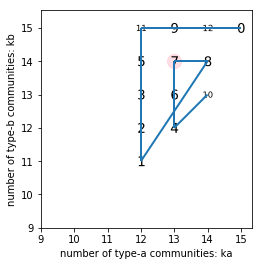

In [9]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

trace = list(oks.trace_mb.keys())
lines = []
for ind, i in enumerate(trace):
    if ind != len(trace) - 1:
        lines += [(trace[ind], trace[ind+1])]

lc = mc.LineCollection(lines, linewidths=2)
fig, ax = plt.subplots()
ax.add_collection(lc)

# Pink circle marks the optimal point (ka, kb)
p_estimate = sorted(oks.confident_desc_len, key=oks.confident_desc_len.get)[0]
ax.scatter(p_estimate[0], p_estimate[1], marker="o", c="pink", s=200, alpha=0.5)

# Black numbers indicate ordered points where graph partition takes place
for idx, point in enumerate(oks.confident_desc_len.keys()):
    plt.scatter(point[0], point[1], marker='${}$'.format(idx), c="black", edgecolors="none", s=100)

ax.autoscale()
ax.margins(0.1)

ax.set_aspect(1)
plt.xlabel("number of type-a communities: ka")
plt.ylabel("number of type-b communities: kb")
plt.xticks(range(9, 16))
plt.yticks(range(9, 16))

plt.show()